# DEA-LaserCom research notebook

## ILD1320 sensor interface

See the [operation manual](https://www.micro-epsilon.com/download/manuals/man--optoNCDT-1320--en.pdf) for this sensor for the references cited throughout this document.

In [213]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import clear_output
import time

Let's first install [pySerial](https://pythonhosted.org/pyserial/pyserial.html).

In [2]:
try:
    import serial
except:
    import sys
    !{sys.executable} -m pip install pyserial --user
    import serial

This class gives us an interface for working with bidirectional streams.

In [3]:
class StreamInterface:
    def __init__(self, stream, encoding, eol):
        self.stream = stream
        self.encoding = encoding
        self.eol = eol.encode(self.encoding)
        
    def write(self, message, return_response=False):
        self.stream.write(message.encode(self.encoding) + self.eol)
        if return_response:
            if isinstance(return_response, int): return self.stream.read(return_response)
            else: return self.stream.readlines()
        else: return None

To communicate with the ILD1320 sensor, we are using 8 data bits and no stop bits. The data are sent from the sensor as three-byte packets, low-to-high:

|         |   |   |   |   |   |   |   |   |   |
|---------|---|---|---|---|---|---|---|---|---|
| $L$-Byte | $0$ | $0$ || $D5$ | $D4$ | $D3$ | $D2$ | $D1$ | $D0$ |
| $M$-Byte | $0$ | $1$ || $D11$ | $D10$ | $D9$ | $D8$ | $D7$ | $D6$ |
| $H$-Byte | $1$ | $0$ || $(D^*)$ | $(D17)$ | $(D16)$ | $D15 $| $D14$ | $D13$ |

The $D$-bits are put together in decreasing order of index (big-endian). Every observation cycle, each output parameter is individually sent in such a three-byte block, with effective data width between 16 and 18 bits ($D0$ - $D16, D18$). Since multiple output parameters can be chosen via `OUTADD_RS422` (Appendix A 3.5.3.2) for each observation cycle, bit $D^*$ is $0$ when the current three-byte block is the first in its observation cycle.
See section 7.2.2 of the [operation manual](https://www.micro-epsilon.com/download/manuals/man--optoNCDT-1320--en.pdf) for more details on the encoding scheme.

Using the formula provided in section 7.2.2, we can calculate the distance in millimeters. The `observe` function returns the $x$ in that expression. Measuring range is given in millimeters.

In [4]:
class ILD1320(StreamInterface):
    def __init__(self, stream, encoding='ascii', eol='\r\n', **kwargs):
        super().__init__(stream, encoding, eol)
        self.__dict__.update({
            "measuring_range": 100,
            "start_of_measuring_range": 50
        })
        self.__dict__.update(kwargs)
    
    def observe(self):
        while True: # until we get the first low-order byte
            l = int.from_bytes(self.stream.read(1), byteorder="big")
            #print(format(l, '#010b'))
            if ((l >> 6) != 0): continue
        
            m = int.from_bytes(self.stream.read(1), byteorder="big")
            #print(format(m, '#010b'))
            if ((m >> 6) != 1): continue
            
            h = int.from_bytes(self.stream.read(1), byteorder="big")
            #print(format(h, '#010b'))
            if ((h >> 6) != 2): continue
        
            # currently inelegant solution to buffer problem
            self.stream.reset_input_buffer()
            return ((h & 0x3f) << 12) | ((m & 0x3f) << 6) | (l & 0x3f)
    
    def distance(self, sleep=0):
        if sleep > 0: time.sleep(sleep)
        return ((1/100)*(((102*self.observe())/65520)-1)*self.measuring_range) + self.start_of_measuring_range

By using the `by-id` directory, which simlinks info `/dev/tty`, you can reference the serial device by its unique ID.

In [5]:
ild1320_stream = serial.Serial(
    '/dev/serial/by-id/usb-Micro-Epsilon_Micro-Epsilon_IF2001_USB_002988-if00-port0', 
    baudrate=921000, timeout=0
)

ild1320 = ILD1320(ild1320_stream)

Mastering is disabled until I can create an object-oriented implementation. We probably don't need it for our measurements, anyway.

In [6]:
for command in ['TRIGGER NONE', 'OUTHOLD NONE', 'MEASPEAK DISTA', 'MEASRATE 2', 
                'OUTPUT RS422', 'ECHO OFF', 'MASTERMV NONE', 'LASERPOW FULL']:
    ild1320.write(command)

Using the formula provided in section 7.2.2, we can calculate the distance in millimeters. The function above returns the `x` in that expression. Measuring range is given in millimeters.

Here's an infinite loop (with updating) to show raw distances from the sensor.

In [54]:
def ild1320_continuous_measurement():
    try:
        while True:
            clear_output(wait=True)
            print(ild1320.distance())
            print(ild1320.stream.in_waiting)
            time.sleep(0.09)
    except KeyboardInterrupt:
        clear_output(wait=True)
        
ild1320_continuous_measurement()

104.49285714285713
0


Now we integrate the with the ESP32 microcontroller that controls PWM voltage output to the actuator.

## Dielectric elastomer actuator remote interface

In [76]:
class DEAController(StreamInterface):
    def __init__(self, stream, encoding='ascii', eol='', **kwargs):
        super().__init__(stream, encoding, eol)
        
    def pwm(self, i):
        self.write(str(max(min(float(i), 100.), -100.)))

In [77]:
dea_stream = serial.Serial(
    '/dev/serial/by-id/usb-Silicon_Labs_CP2102N_USB_to_UART_Bridge_Controller_e22272fd3499e8119165bc20c3e5cfbd-if00-port0', 
    baudrate=921600, timeout=0
)

dea = DEAController(dea_stream)

We address the microcontroller with a string encoding a floating-point number that gives the desired duty cycle from `full_duty_voltage` kV. We need two archetypal loops: an inner loop for measuring elastomer displacement every `sample_intr` seconds, up to `rest_intr` seconds, with a constant duty cycle; and an outer loop for adjusting the duty cycle every `rest_intr` seconds and maintaining continuous sampling throughout by calling the inner loop.

Note that sampling happens essentially continuously, every `sample_intr` seconds. So time is kept discrete, but it can be easily calculated from the parameters above.

I will introduce a callback for the sencor

In [79]:
import csv
import functools
from datetime import datetime

class DEATester:
    def __init__(self, dea, sensor, intervals={}):
        self.dea = dea
        self.sensor = sensor
        self.intervals = intervals
        self.figsize = (7, 5)
        self.seconds_left = 0
        self.reset()
        
    def reset(self):
        self.xs = []
        self.ys = []
        self.seconds_left = 0

    def measure_loop(self, rest=None):
        clear_output(wait=True)
        if rest is None: rest = self.pwm_range[0]
        samples = int(self.intervals['hold']/self.intervals['sample'])
        self.dea.pwm(rest)
        for i in range(samples):
            print("duty cycle: {}\nsamples: {} / {}".format(rest, i + 1, samples))
            dist = round(self.sensor.distance(), 4)
            if dist == 456.9938:
                raise ValueError("Sensor entered error state")
                
            print("observation: {} mm".format(dist))
            tester.ys.append(dist)
            tester.xs.append(rest)
            time.sleep(self.intervals['sample'])
            clear_output(wait=True)
            
    def increment_loop(self, range=[0., 100], reverse=False):
        pwm_range = np.arange(*range, -self.intervals['pwm'] if reverse else self.intervals['pwm'])
        self.seconds_left = 0
        for pwm in pwm_range:
            if self.intervals['hold'] > 0: 
                self.measure_loop(pwm)
                
            clear_output(wait=True)
            if self.intervals['rest'] > 0:
                self.dea.pwm(0)
                print("resting: {} duty cycle, {} sec".format(0, self.intervals['rest']))
                time.sleep(self.intervals['rest'])
                

    def export(self, prefix="data"):
        with open(
            "{}-{}-{}-{}-{}-{}.csv".format(
                prefix,
                time.strftime("%Y%m%d-%H%M%S"),
                *[interval for interval in self.intervals.values()]
            ), 'w') as csvfile:
            wr = csv.writer(csvfile)
            for x, y in zip(self.xs, self.ys):
                wr.writerow([x, y])
                
    def to_df(self):
        return pd.DataFrame({"t": range(len(self.xs)), "d": self.ys, "v": self.xs})

tester = DEATester(dea, ild1320)

Now we cycle actuation up and down, with measurement at the extremes to account for viscoelasticity.

In [113]:
tester.intervals = {
    "sample": 0.5,
    "rest": 5,
    "hold": 5,
    "pwm": 10
}

tester.reset()
loops = 1
try:
    for loop in range(loops):
        #tester.increment_loop([100., -100.])
        #tester.increment_loop([100., -100.], reverse=True)
        tester.increment_loop([0., 105.])
        #tester.increment_loop([100., -100.], reverse=True)
except KeyboardInterrupt:
    tester.dea.pwm(0)
except:
    tester.dea.pwm(0)
    raise
    
dea.pwm(0)

resting: 0 duty cycle, 5 sec


If we are keeping duty cycle constant, we can just plot displacement against time:

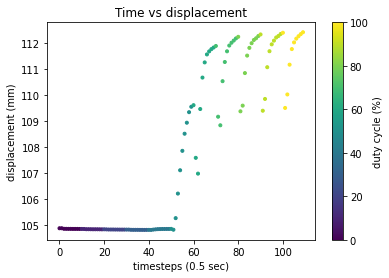

In [114]:
plt.scatter(range(len(tester.ys)), tester.ys, c=tester.xs, marker='.');
plt.title("Time vs displacement");
plt.colorbar(label="duty cycle (%)");
plt.xlabel("timesteps ({} sec)".format(tester.intervals['sample']));
plt.ylabel("displacement (mm)");

In [115]:
plt.scatter(tester.ys, tester.xs, c=range(len(tester.ys)), marker='.');
plt.title("Displacement vs duty cycle");
plt.colorbar(label="timesteps ({} sec)".format(tester.intervals['sample']));
plt.ylabel("duty cycle (%)");
plt.xlabel("displacement (mm)");

With the data from a full test, we can generate a 3D plot of time versus voltage versus displacement to see viscoelasticity in action.

In [116]:
%matplotlib inline
from mpl_toolkits import mplot3d

ax = plt.axes(projection='3d')
ax.scatter3D(tester.ys, range(len(tester.ys)), tester.xs, c='g', cmap='Greens');

## Machine learning adventures

### Basic polynomial fitting

We wish to model a function $d(v, t)$ that gives voltage as a function of time and desired displacement. We will follow the path described in "Deep Reinforcement Learning in Soft Viscoelastic Elastomer" (Li et al, 2019). The authors fit a 4-th order polynomial $v = P_t(d)$ to voltage-displacement pairs at each given point in time.

To obtain this data, we will first gather data on 5% voltage steps for 15 seconds, with a 10 second rest period in between each actuation.

In [135]:
tester.intervals = {
    "sample": 0.1,
    "rest": 10,
    "hold": 20,
    "pwm": 5
}

tester.reset()
loops = 1
try:
    for loop in range(loops):
        tester.increment_loop([40., 105.])
        
    tester.export()
except KeyboardInterrupt:
    tester.dea.pwm(0)
except:
    tester.dea.pwm(0)
    raise
    
dea.pwm(0)

resting: 0 duty cycle, 10 sec


Let's examine the difference between taking a break and not taking a break:

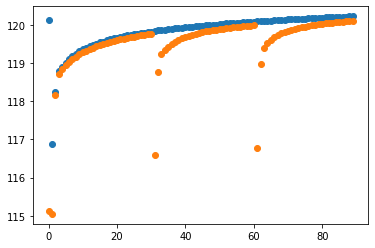

In [178]:
df_break = pd.read_csv("data-20200606-153135-0.5-5-15-5.csv", names=['v', 'd'])
df_break['t'] = df_break.index

df_no_break = pd.read_csv("data-20200606-153445-0.5-0-15-5.csv", names=['v', 'd'])
df_no_break['t'] = df_no_break.index

plt.scatter(df_no_break.t, df_no_break.d)
plt.scatter(df_break.t, df_break.d)

It is also possible to import data directly from the CSV that we wisely created above. Note that the timestamps must be recreated, as they are not stored.

In [144]:
df = tester.to_df()

#df = pd.read_csv("data-20200607-170250-0.1-10-20-5.csv", names=['v', 'd'])
#df['t'] = df.index

#tester.intervals = {
#    "sample": 0.1,
#    "rest": 10,
#    "hold": 20,
#    "pwm": 5
#}
df

t         d      v
0        0  110.5098   40.0
1        1  107.3745   40.0
2        2  106.1353   40.0
3        3  106.1430   40.0
4        4  106.1462   40.0
...    ...       ...    ...
2595  2595  112.8496  100.0
2596  2596  112.8418  100.0
2597  2597  112.8527  100.0
2598  2598  112.8574  100.0
2599  2599  112.8527  100.0

[2600 rows x 3 columns]

In [137]:
df['t'] = df['t'].apply(lambda x: x % (tester.intervals['hold'] / tester.intervals['sample']))
groups = df.groupby([df.t])

In [208]:
from numpy.polynomial import Polynomial

polys = groups.apply(lambda x: Polynomial.fit(x.d, x.v, 3)).to_list()
print("Samples: {}\nCurves:  {}".format(len(df.v), len(polys)))

Samples: 2600
Curves:  200


Let's see how our fitted plolynomials look.

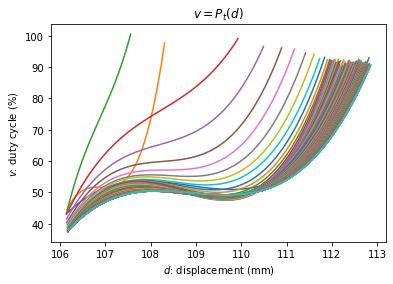

In [209]:
for poly, group in zip(polys, groups):
    plt.title("$v = P_t(d)$")
    plt.plot(*(poly.linspace()))
    plt.xlabel("$d$: displacement (mm)")
    plt.ylabel("$v$: duty cycle (%)")

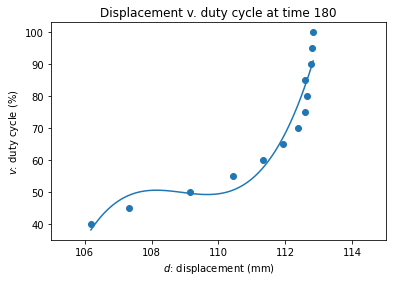

In [210]:
# plt.plot(*(polys[199].linspace()))
t = 180

plt.plot(*(polys[t].linspace()))

points = groups.get_group(t)
plt.scatter(points.d, points.v)
plt.xlim(left=105, right = 115)
plt.title("Displacement v. duty cycle at time {}".format(t))
plt.xlabel("$d$: displacement (mm)");
plt.ylabel("$v$: duty cycle (%)");

Let's try to replicate the experiment shown in the Singapore paper: Generate a sine wave, and see how well the elastomer can follow it with this polynomial approximation alone. We use a simple measuring framework, with one-to-one correspondence between target points and polynomials. Thus, each ploynomial is in a sense "single-use" -- it is only used for the exact timestemp for which it is calculated.

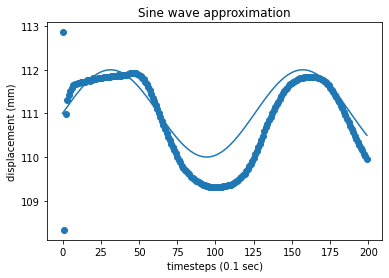

In [214]:
tester.dea.pwm(0)
# time.sleep(5)
# center = round(tester.sensor.distance(), 2)
center = 111.0
xs = []
ys = []
ds = []
ts = []

# test_duration: spread out the test data

# Target.
sinx = np.arange(0, tester.intervals['hold'] / tester.intervals['sample'], 1)
siny = np.sin(sinx / tester.intervals['hold'] * 1) + center
plt.plot(sinx, siny)

# Actual.
pwm = 0
i = 0
for y, poly in zip(siny, polys):
    duty = round(poly(y), 2)
    xs.append(y)
    ys.append(max(min(duty, 100), -100))
    print("center: {}, last displacement: {}, next displacement: {}; predicted duty cycle: {}".format(round(center, 2), ds[-1] if ds else center, round(y, 2), duty))
    tester.dea.pwm(duty)
    time.sleep(tester.intervals['sample'])
    ds.append(round(tester.sensor.distance(), 2))
    ts.append(i)
    i += 1
    clear_output(wait=True)
    
tester.dea.pwm(0)

plt.scatter(ts, ds);
plt.title("Sine wave approximation");
plt.xlabel("timesteps ({} sec)".format(tester.intervals['sample']));
plt.ylabel("displacement (mm)");

Let's also measure the voltage output over time.

(0.0, 105.0)

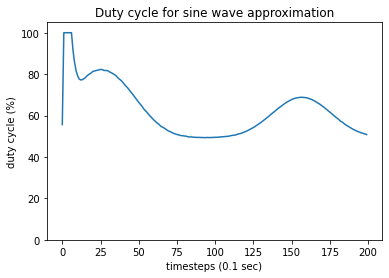

In [215]:
plt.plot(ts, ys);
plt.title("Duty cycle for sine wave approximation");
plt.xlabel("timesteps ({} sec)".format(tester.intervals['sample']));
plt.ylabel("duty cycle (%)");
plt.ylim(bottom=0, top=105)

In [98]:
pd.DataFrame({"t": ts,"x": xs, "y": ys, "d": ds}).tail(50)

ValueError: arrays must all be same length

In [216]:
rmse = np.sqrt(((siny - ys) ** 2).mean())
print("RMSE: {} mm".format(rmse.round(3)))

RMSE: 49.909 mm


Another interesting investigation is seeing how long it takes for the distance to change within a certain tolerance at a given duty cycle. This could also give valuable insight into hysteresis, and it could tell us how many polynomials we need for each duty cycle. We can use the power of Python here to customize the basic inner and outer loops that I have written.